# Using a CNN to Identify Fashion


In [2]:
! unzip /content/drive/MyDrive/archive\(2\).zip

## Dataset Exploration and Label Distribution Analysis

<ipython-input-30-754dc42acd2b>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pic = imageio.imread(os.path.join(base_path, random_pic_path))


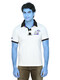

Original height, width, and channels of each image: 80 60 3


In [30]:
import imageio
import os
import glob
from collections import Counter
import random
myseed = 12345  # set a random seed for reproducibility

from google.colab.patches import cv2_imshow

base_path = './myntradataset/images/'

# let's take a look at one random image

random_pic_path = random.choice(os.listdir(os.path.join(base_path, )))
pic = imageio.imread(os.path.join(base_path, random_pic_path))
cv2_imshow(pic)
height, width, channels = pic.shape
print(f'Original height, width, and channels of each image: {height} {width} {channels}')




## Setup Libaries and GPU

In [31]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

from tqdm.auto import tqdm
import random

In [32]:
# basic setup for PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [57]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((80, 60)),  # all images are 80 x 60 anyways
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert image to RGB
    transforms.ToTensor(),  # Convert the image to a tensor
])
# they're the same, but will be adjusted eventually for data augmentation
test_transforms = transforms.Compose([
    transforms.Resize((80, 60)),  # all images are 80 x 60 anyways
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert image to RGB
    transforms.ToTensor(),  # Convert the image to a tensor
])

## Dataset Class for DataLoader

In [45]:
class FashionDataset(Dataset):
    def __init__(self, csv_path, images_path, tfm=None):
        """
        csv_path: Path to the train.csv or test.csv file.
        images_path: Base path where the images are stored.
        tfm: Transforms to be applied on the images.
        """
        self.data = pd.read_csv(csv_path, sep='\t')
        self.images_path = images_path
        self.transform = tfm

        # Creating a dictionary to convert label names to integers
        self.label_dict = {label: idx for idx, label in enumerate(self.data['label'].unique())}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0])  #first column is id
        label_name = self.data.iloc[idx, 1]  # second column is the label
        img_path = os.path.join(self.images_path, img_name + ".jpg")

        image = Image.open(img_path)

        # Ensure all images are in RGB
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.label_dict[label_name]

        return image, label

## Convolutional Neural Net Setup

In [52]:
# Initialize the dataset
train_dataset = FashionDataset(
    csv_path='/content/drive/MyDrive/CNN Fashion data/train.csv',
    images_path='/content/images',
    tfm=train_transforms
)

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class AdjustedCNN(nn.Module):
    def __init__(self):
        super(AdjustedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # output: 80x60
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 40x30
        # after two pooling layers, the size will be 20x15 (80 -> 40 -> 20, 60 -> 30 -> 15)
        self.fc1 = nn.Linear(64 * 20 * 15, 128)
        self.fc2 = nn.Linear(128, 13) # 13 classes

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # pooling halves the dimensions: 80x60 -> 40x30
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # again halving: 40x30 -> 20x15
        x = x.view(-1, 64 * 20 * 15) # flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [49]:
import torch.optim as optim

model = AdjustedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
from torch.utils.data import DataLoader
import torch

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.5106
Epoch [2/10], Loss: 0.7534
Epoch [3/10], Loss: 0.2266
Epoch [4/10], Loss: 0.2449
Epoch [5/10], Loss: 0.2307
Epoch [6/10], Loss: 0.0577
Epoch [7/10], Loss: 0.0336
Epoch [8/10], Loss: 0.0625
Epoch [9/10], Loss: 0.0120
Epoch [10/10], Loss: 0.0134


In [79]:
test_dataset = FashionDataset(
    csv_path='/content/drive/MyDrive/CNN Fashion data/test.csv',
    images_path='/content/images',
    tfm=test_transforms

)
label_dict = test_dataset.label_dict

In [66]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [74]:

with torch.no_grad():
    model.eval()

    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 99.95%


## Testing on random individual images

In [85]:
from torchvision import transforms
from PIL import Image
import torch
import os

# if you want to test on an 80x60 image, put it in here
image_base_path = '/content/images'
image_file_name = '33262.jpg'
image_path = os.path.join(image_base_path, image_file_name)

In [86]:

image = Image.open(image_path).convert('RGB')


transformed_image = test_transforms(image)

# Add a batch dimension
transformed_image = transformed_image.unsqueeze(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformed_image = transformed_image.to(device)
model = model.to(device)


model.eval()
with torch.no_grad():
    outputs = model(transformed_image)
    _, predicted = torch.max(outputs, 1)
    predicted_index = predicted.item()


idx_to_label = {v: k for k, v in label_dict.items()}


predicted_label = idx_to_label[predicted_index]

print(f'The model predicts: {predicted_label}')

The model predicts: Topwear
